<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/lstm_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long short term memory (LSTM) 

We show how to implement LSTMs from scratch.
Based on sec 9.2 of http://d2l.ai/chapter_recurrent-modern/lstm.html.
This uses code from the [basic RNN colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/rnn_torch.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math

import torch
from torch import nn
from torch.nn import functional as F

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

# Data

 As data, we use the book "The Time Machine" by H G Wells,
preprocessed using the code in [this colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/text_preproc_torch.ipynb).

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# Creating model from scratch

In [3]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # Input gate parameters
    W_xf, W_hf, b_f = three()  # Forget gate parameters
    W_xo, W_ho, b_o = three()  # Output gate parameters
    W_xc, W_hc, b_c = three()  # Candidate memory cell parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [4]:
# The state is now a tuple of hidden state and cell state
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))
    

In [5]:
# forward function
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)


# Training and prediction

perplexity 1.1, 35010.5 tokens/sec on cuda:0
time traveller but now you babk go vevinytwy cedthat is and shat
travellericbut at sithtraun andmartentic fourth cald theimm


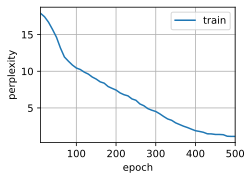

In [6]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# Using pytorch module

perplexity 1.0, 348442.9 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


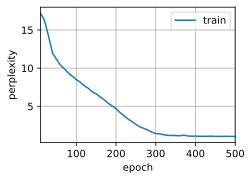

In [7]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)